*Resampling methods* involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain additional information about the fitted model. Such an approach may allow us to obtain information that would not be available from fitting the model only once using the origin training sample.  

In this chapter, we will discuss two of the most commonly used resampling methods, *cross-validation* and *bootstrap*. Cross-validation can be used tto estimate the test error associated with a given statistical learning method in order to evaluate its performance, or to select the appropriate level of flexibility. The process of evaluating a model's performance is known as *model assessment*, whereas the process of selecting the proper level of flexibility for a model is known as *model selection*. The bootstrap is used in several contexts, most commonly to provide a measure of accuracy of a parameter estimate or of a given statistical learning method.

# Cross-Validation  
In the absence of a very large designated test set that can be used to directly estimate the test error rate, a number of techniques can be used to estimate this quantity using the available training data. In this section, we consider a class of methods that estimate the test error rate by *holding out* a subset of the training observations from the fitting process, then applying the statistical learning method to those held out observations.  

## The Validation Set Approach
The *validation set approach* is a very simple strategy for estimating the test error associated with fitting a particular statistical learning method on a set of observations. It involves randomly dividing the available set of observations into two parts, a *training set* and a *validation set* or *hold-out* set. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate (typically assessed using MSE for quantitative responses), provides an estimate of the test error rate.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures as poly

%matplotlib inline

In [2]:
auto = pd.read_csv('../../data/Auto.csv', na_values='?')
auto.dropna(inplace=True)

X = auto['horsepower'].values.reshape(-1, 1)
y = auto['mpg'].values

[<matplotlib.text.Text at 0x20653710>, <matplotlib.text.Text at 0x201fee80>]

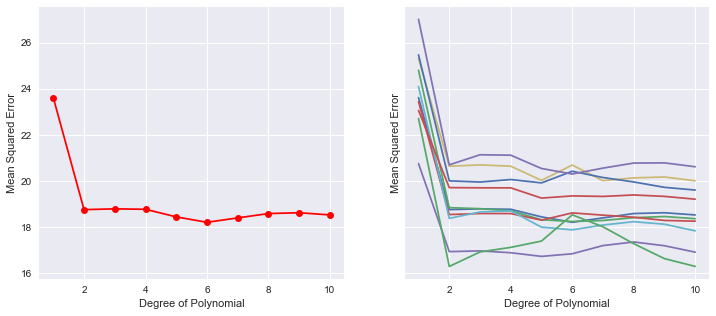

In [4]:
#Figure 5.2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

deg = np.arange(1, 11)
lr = LinearRegression()

#left paneel
mse = []
for d in deg:
    p = poly(d)
    X_poly = p.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.5, random_state=0)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
ax1.plot(deg, mse, '-ro')
ax1.set(xlabel='Degree of Polynomial', ylabel='Mean Squared Error')

#right panel
#hard coding the random states because rs = 5 or 9 produce very bad plots (this is bad practice)
rs=[0, 1, 2, 3, 4, 6, 7, 8, 10, 12]
for i in range(10):
    mse = []
    for d in deg:
        p = poly(d)
        X_poly = p.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.5, random_state=rs[i])
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        mse.append(mean_squared_error(y_test, y_pred))
    ax2.plot(deg, mse, label=str(i))
ax2.set(xlabel='Degree of Polynomial', ylabel='Mean Squared Error')

In the left panel, we use a single 50-50 random split on the data to estimate the test error using the validation set MSE. In the right panel, we used 10 different 50-50 random splits of the data. Although there is no consensus among the curves as to which model results in the smallest validation set MSE, we can conclude that the linear fit is not adequate for this data.  

The validation set approach is simple and easy to implement, but has two potential drawbacks:  

 1. As shown in the right panel, the validatioin estimate of the test error rate can be highly variable, depending on precisely which obsrvations are included in the training set and which obsrvations are included in the validation set.  
 2. Since only a subset of the observations are used to fit the model, the validation set error rate may tend to *overestimate* the test error rate. This is because statistical methods tend to perform worse when trained on fewer observations.  

## Leave-One-Out Cross-Validation
*Leave-one-out cross-validation* (LOOCV) is closely related to the validation set approach, but it attempts to address that method's drawbacks.  

LOOCV involves splitting the observations into two parts, but instead of creating two subsets of comparable size, a single observation $(x_1, y_1)$ is used for the validation set, and the remaining observations $\{(x_2, y_2, ..., (x_n, y_n)\}$ make up the training set. The statistical method is fit on the $n-1$ training observations and the prediction $\widehat{y}_1$ is made for the excluded observation. Since $(x_1, y_1)$ was not used in the fitting process, $MSE_1=(y_1 - \widehat{y}_1)^2$ provides an approximately unbiased estimate for the test error. Although $MSE_1$ is unbiased for the test error, it's a poor estimate because it is highly variable.  

We can repeat this approach $n$ times to produce $n$ squared errors, $MSE_1, ..., MSE_n$. The LOOCV estimate for the test MSE is the average of these $n$ test error estimates:  

$$CV_{(n)}=\frac{1}{n}\sum_{i=1}^nMSE_i$$  

LOOCV has a couple of advantages over the validation set approach:  
 
 1. It has far less bias since we repeatedly fit the statistical learning method using training sets that contain $n-1$ observations. Consequently, it tends not to overestimate the test error rate as much as the validation approach.  
 2. Unlike the validation set approach, performing LOOCV multiple times will always yield the same results because there is no randomness to the training/validation set splits.